# Cat vs Dog Model Benchmark
Comprehensive testing on 12,500 test images

In [19]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from datetime import datetime
from PIL import Image
import xlsxwriter
from io import BytesIO

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Model and Configuration

In [21]:
# Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
TEST_FOLDER = 'test_images'
MODEL_PATH = 'models/model.keras'
OUTPUT_EXCEL = 'test_predictions.xlsx'

# Load the trained model
print("Loading model...")
model = load_model(MODEL_PATH)
print("✓ Model loaded successfully\n")

Loading model...
✓ Model loaded successfully

✓ Model loaded successfully



## 2. Batch Prediction Function

In [22]:
def predict_test_images(image_folder, model, batch_size=32):
    """
    Predict all images in the test folder
    
    Args:
        image_folder: Path to folder containing test images
        model: Loaded Keras model
        batch_size: Number of images to process at once
        
    Returns:
        DataFrame with predictions
    """
    # Get all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    total_images = len(image_files)
    print(f"Found {total_images} test images")
    print(f"Processing in batches of {batch_size}...\n")
    
    results = []
    
    # Process images in batches
    for i in range(0, total_images, batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_images = []
        
        # Load batch of images
        for img_file in batch_files:
            img_path = os.path.join(image_folder, img_file)
            try:
                img = image.load_img(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
                img_array = image.img_to_array(img) / 255.0  # Normalize
                batch_images.append(img_array)
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
                batch_images.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
        
        # Predict batch
        batch_array = np.array(batch_images)
        predictions = model.predict(batch_array, verbose=0)
        
        # Store results
        for img_file, pred in zip(batch_files, predictions):
            raw_score = float(pred[0])
            predicted_class = "Dog" if raw_score > 0.5 else "Cat"
            confidence = raw_score if raw_score > 0.5 else (1 - raw_score)
            
            results.append({
                'image_id': img_file.replace('.jpg', ''),
                'filename': img_file,
                'prediction': predicted_class,
                'confidence': confidence,
                'dog_probability': raw_score,
                'cat_probability': 1 - raw_score
            })
        
        # Progress update
        processed = min(i + batch_size, total_images)
        if processed % 1000 == 0 or processed == total_images:
            print(f"Processed: {processed}/{total_images} images ({processed/total_images*100:.1f}%)")
    
    return pd.DataFrame(results)

## 3. Run Predictions

In [23]:
# Run batch predictions
print("="*70)
print("STARTING BATCH PREDICTION")
print("="*70)
print()

start_time = datetime.now()
results_df = predict_test_images(TEST_FOLDER, model, batch_size=64)
end_time = datetime.now()

duration = (end_time - start_time).total_seconds()

print()
print("="*70)
print("PREDICTION COMPLETED")
print("="*70)
print(f"Total time: {duration:.2f} seconds")
print(f"Average time per image: {duration/len(results_df)*1000:.2f} ms")
print("="*70)

STARTING BATCH PREDICTION

Found 12500 test images
Processing in batches of 64...

Processed: 8000/12500 images (64.0%)
Processed: 8000/12500 images (64.0%)
Processed: 12500/12500 images (100.0%)

PREDICTION COMPLETED
Total time: 57.79 seconds
Average time per image: 4.62 ms
Processed: 12500/12500 images (100.0%)

PREDICTION COMPLETED
Total time: 57.79 seconds
Average time per image: 4.62 ms


## 4. Save Results to Excel with Images

In [24]:
# Save predictions to Excel with embedded images
print("\nCreating Excel file with images...")
print("This may take a few minutes for 12,500 images...")

# Create Excel writer object
workbook = xlsxwriter.Workbook(OUTPUT_EXCEL)
worksheet = workbook.add_worksheet('Predictions')

# Define formats
header_format = workbook.add_format({
    'bold': True,
    'bg_color': '#4472C4',
    'font_color': 'white',
    'align': 'center',
    'valign': 'vcenter',
    'border': 1
})

cell_format = workbook.add_format({
    'align': 'center',
    'valign': 'vcenter',
    'border': 1
})

confidence_format = workbook.add_format({
    'align': 'center',
    'valign': 'vcenter',
    'border': 1,
    'num_format': '0.00%'
})

# Write headers
headers = ['Row', 'Image', 'Image ID', 'Filename', 'Prediction', 'Confidence', 'Dog Probability', 'Cat Probability']
for col, header in enumerate(headers):
    worksheet.write(0, col, header, header_format)

# Set column widths
worksheet.set_column(0, 0, 8)   # Row number
worksheet.set_column(1, 1, 20)  # Image column (wider)
worksheet.set_column(2, 2, 12)  # Image ID
worksheet.set_column(3, 3, 15)  # Filename
worksheet.set_column(4, 4, 12)  # Prediction
worksheet.set_column(5, 7, 15)  # Confidence columns

# Set default row height for images
worksheet.set_default_row(100)

# Write data and insert images
print(f"Writing {len(results_df)} rows to Excel...")
for idx, row in results_df.iterrows():
    excel_row = idx + 1  # +1 because row 0 is header
    
    # Write row number
    worksheet.write(excel_row, 0, excel_row, cell_format)
    
    # Insert image in column B (index 1)
    img_path = os.path.join(TEST_FOLDER, row['filename'])
    try:
        # Load and resize image for Excel
        img = Image.open(img_path)
        img.thumbnail((120, 120))  # Resize to fit in cell
        
        # Save to BytesIO buffer
        img_buffer = BytesIO()
        img.save(img_buffer, format='PNG')
        img_buffer.seek(0)
        
        # Insert image into Excel
        worksheet.insert_image(excel_row, 1, img_path, {
            'image_data': img_buffer,
            'x_scale': 0.5,
            'y_scale': 0.5,
            'x_offset': 5,
            'y_offset': 5
        })
    except Exception as e:
        worksheet.write(excel_row, 1, f"Error: {str(e)[:20]}", cell_format)
    
    # Write other data
    worksheet.write(excel_row, 2, row['image_id'], cell_format)
    worksheet.write(excel_row, 3, row['filename'], cell_format)
    worksheet.write(excel_row, 4, row['prediction'], cell_format)
    worksheet.write(excel_row, 5, row['confidence'], confidence_format)
    worksheet.write(excel_row, 6, row['dog_probability'], confidence_format)
    worksheet.write(excel_row, 7, row['cat_probability'], confidence_format)
    
    # Progress update
    if (idx + 1) % 1000 == 0:
        print(f"  Written: {idx + 1}/{len(results_df)} rows")

# Close workbook
workbook.close()

print(f"\n✓ Results saved to '{OUTPUT_EXCEL}'")
print(f"  Columns: {headers}")
print(f"  Total rows: {len(results_df)} (+ 1 header)")
print(f"  Images embedded: {len(results_df)}")


Creating Excel file with images...
This may take a few minutes for 12,500 images...
Writing 12500 rows to Excel...
  Written: 1000/12500 rows
  Written: 1000/12500 rows
  Written: 2000/12500 rows
  Written: 2000/12500 rows
  Written: 3000/12500 rows
  Written: 3000/12500 rows
  Written: 4000/12500 rows
  Written: 4000/12500 rows
  Written: 5000/12500 rows
  Written: 5000/12500 rows
  Written: 6000/12500 rows
  Written: 6000/12500 rows
  Written: 7000/12500 rows
  Written: 7000/12500 rows
  Written: 8000/12500 rows
  Written: 8000/12500 rows
  Written: 9000/12500 rows
  Written: 9000/12500 rows
  Written: 10000/12500 rows
  Written: 10000/12500 rows
  Written: 11000/12500 rows
  Written: 11000/12500 rows
  Written: 12000/12500 rows
  Written: 12000/12500 rows

✓ Results saved to 'test_predictions.xlsx'
  Columns: ['Row', 'Image', 'Image ID', 'Filename', 'Prediction', 'Confidence', 'Dog Probability', 'Cat Probability']
  Total rows: 12500 (+ 1 header)
  Images embedded: 12500

✓ Results

## 5. Summary Statistics

In [25]:
# Calculate summary statistics
total_images = len(results_df)
cat_predictions = len(results_df[results_df['prediction'] == 'Cat'])
dog_predictions = len(results_df[results_df['prediction'] == 'Dog'])
avg_confidence = results_df['confidence'].mean()
median_confidence = results_df['confidence'].median()
min_confidence = results_df['confidence'].min()
max_confidence = results_df['confidence'].max()

print("\n" + "="*70)
print("PREDICTION SUMMARY")
print("="*70)
print(f"Total Images Tested:     {total_images:,}")
print(f"Predicted as Cat:        {cat_predictions:,} ({cat_predictions/total_images*100:.2f}%)")
print(f"Predicted as Dog:        {dog_predictions:,} ({dog_predictions/total_images*100:.2f}%)")
print()
print("Confidence Statistics:")
print(f"  Average:               {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")
print(f"  Median:                {median_confidence:.4f} ({median_confidence*100:.2f}%)")
print(f"  Minimum:               {min_confidence:.4f} ({min_confidence*100:.2f}%)")
print(f"  Maximum:               {max_confidence:.4f} ({max_confidence*100:.2f}%)")
print("="*70)


PREDICTION SUMMARY
Total Images Tested:     12,500
Predicted as Cat:        6,078 (48.62%)
Predicted as Dog:        6,422 (51.38%)

Confidence Statistics:
  Average:               0.9719 (97.19%)
  Median:                0.9996 (99.96%)
  Minimum:               0.5004 (50.04%)
  Maximum:               1.0000 (100.00%)


## 6. Top & Bottom Predictions

In [26]:
# Display top 10 most confident predictions
print("\nTop 10 Most Confident Predictions:")
print("-" * 70)
top_10 = results_df.nlargest(10, 'confidence')[['filename', 'prediction', 'confidence']]
print(top_10.to_string(index=False))

print("\n" + "="*70)

# Display top 10 least confident predictions
print("\nTop 10 Least Confident Predictions (Most Uncertain):")
print("-" * 70)
bottom_10 = results_df.nsmallest(10, 'confidence')[['filename', 'prediction', 'confidence']]
print(bottom_10.to_string(index=False))


Top 10 Most Confident Predictions:
----------------------------------------------------------------------
 filename prediction  confidence
 1003.jpg        Dog         1.0
 1006.jpg        Dog         1.0
10086.jpg        Dog         1.0
10094.jpg        Dog         1.0
10135.jpg        Dog         1.0
10146.jpg        Dog         1.0
10283.jpg        Dog         1.0
10315.jpg        Dog         1.0
10332.jpg        Dog         1.0
10342.jpg        Dog         1.0


Top 10 Least Confident Predictions (Most Uncertain):
----------------------------------------------------------------------
 filename prediction  confidence
10921.jpg        Dog    0.500430
 5696.jpg        Cat    0.500884
 4505.jpg        Cat    0.501022
 9327.jpg        Cat    0.501132
 7388.jpg        Dog    0.501317
 9826.jpg        Cat    0.501489
10665.jpg        Cat    0.501507
 2330.jpg        Cat    0.502570
 1708.jpg        Cat    0.502600
10557.jpg        Dog    0.502900


## 7. Visualizations

C:\Users\Aina\AppData\Local\Temp\ipykernel_25492\2231127570.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([cat_conf, dog_conf], labels=['Cat', 'Dog'], patch_artist=True,


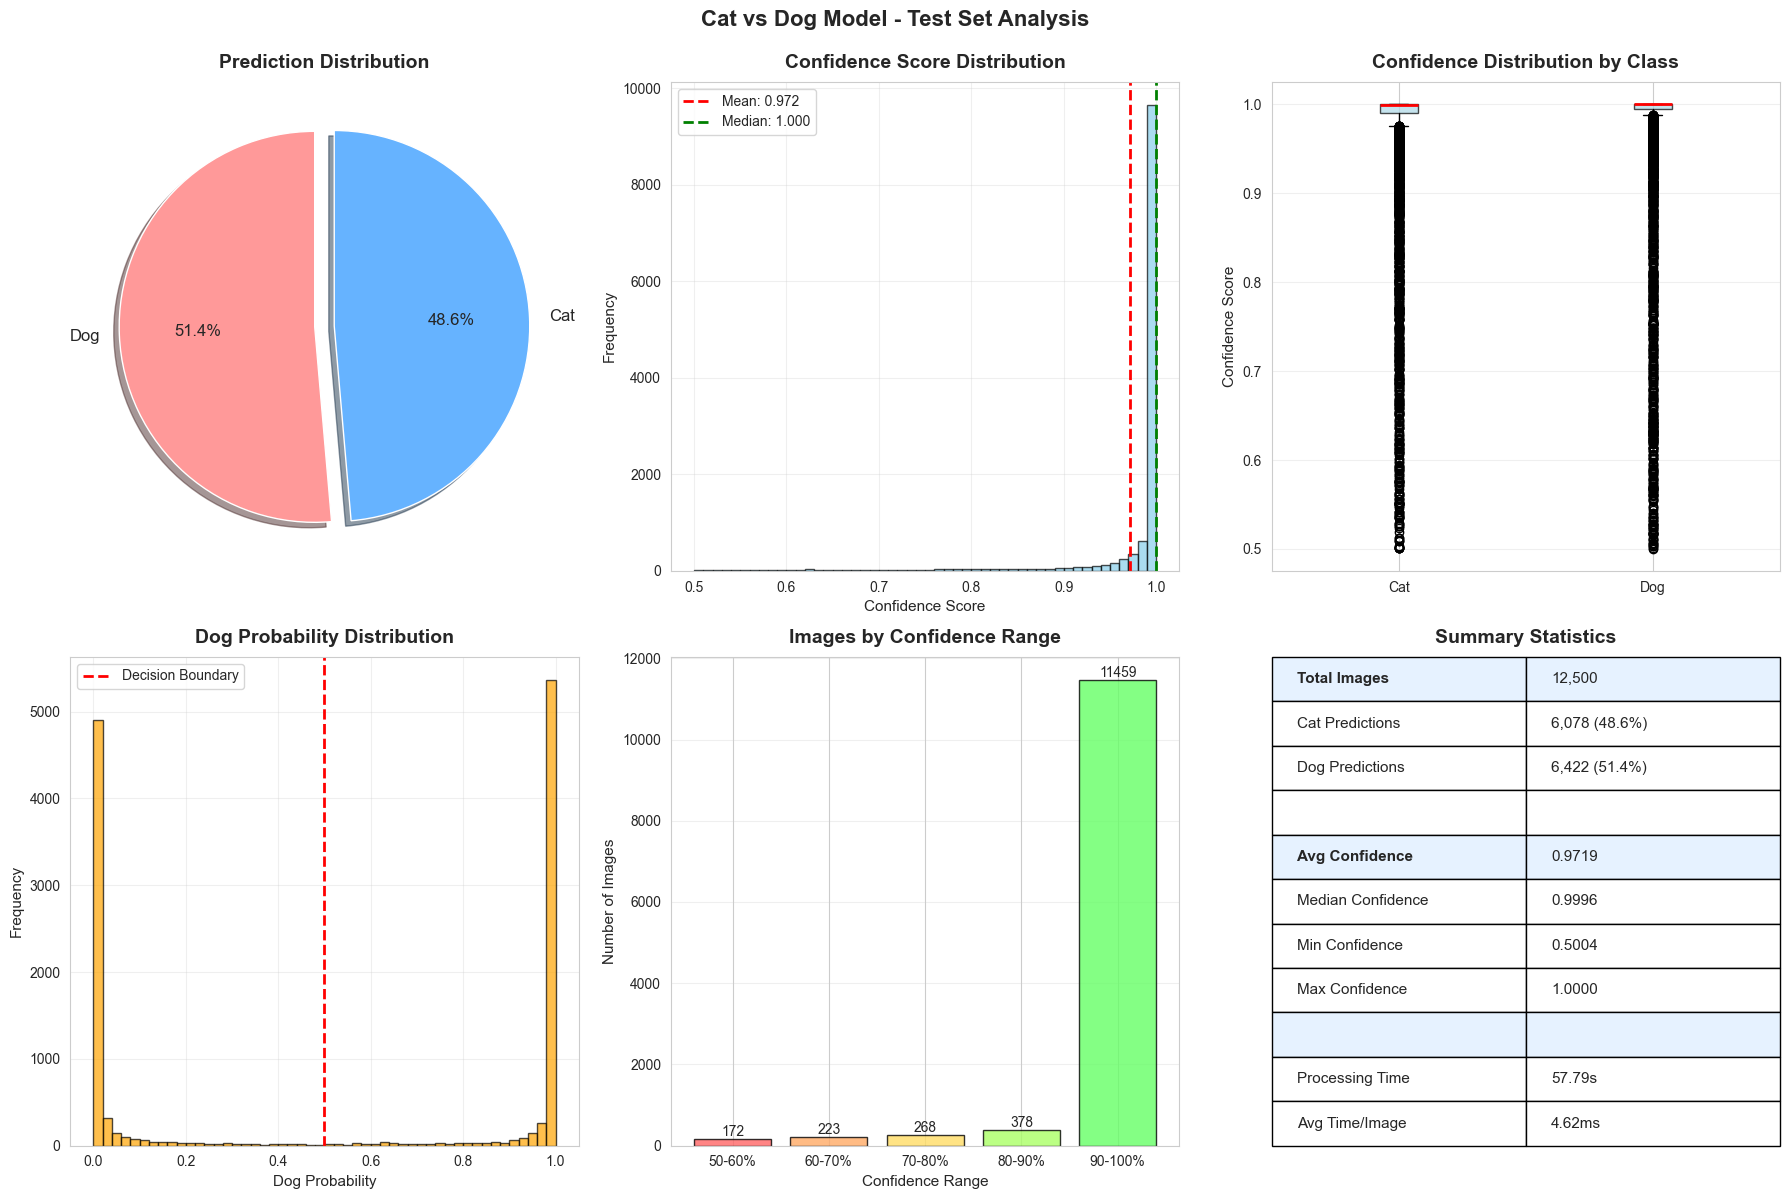


✓ Visualizations saved to 'test_results_visualization.png'


In [27]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cat vs Dog Model - Test Set Analysis', fontsize=16, fontweight='bold', y=0.995)

# 1. Prediction Distribution (Pie Chart)
ax1 = axes[0, 0]
prediction_counts = results_df['prediction'].value_counts()
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0.05)
ax1.pie(prediction_counts.values, labels=prediction_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, shadow=True, textprops={'fontsize': 12})
ax1.set_title('Prediction Distribution', fontsize=14, fontweight='bold', pad=10)

# 2. Confidence Distribution (Histogram)
ax2 = axes[0, 1]
ax2.hist(results_df['confidence'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax2.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_confidence:.3f}')
ax2.axvline(median_confidence, color='green', linestyle='--', linewidth=2, label=f'Median: {median_confidence:.3f}')
ax2.set_xlabel('Confidence Score', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold', pad=10)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confidence by Class (Box Plot)
ax3 = axes[0, 2]
cat_conf = results_df[results_df['prediction'] == 'Cat']['confidence']
dog_conf = results_df[results_df['prediction'] == 'Dog']['confidence']
bp = ax3.boxplot([cat_conf, dog_conf], labels=['Cat', 'Dog'], patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
ax3.set_ylabel('Confidence Score', fontsize=11)
ax3.set_title('Confidence Distribution by Class', fontsize=14, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Dog Probability Distribution (Histogram)
ax4 = axes[1, 0]
ax4.hist(results_df['dog_probability'], bins=50, color='orange', edgecolor='black', alpha=0.7)
ax4.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Boundary')
ax4.set_xlabel('Dog Probability', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Dog Probability Distribution', fontsize=14, fontweight='bold', pad=10)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Confidence Ranges (Bar Chart)
ax5 = axes[1, 1]
bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
confidence_ranges = pd.cut(results_df['confidence'], bins=bins, labels=labels)
range_counts = confidence_ranges.value_counts().sort_index()
bars = ax5.bar(range_counts.index, range_counts.values, color=['#ff6666', '#ffaa66', '#ffdd66', '#aaff66', '#66ff66'], 
               edgecolor='black', alpha=0.8)
ax5.set_xlabel('Confidence Range', fontsize=11)
ax5.set_ylabel('Number of Images', fontsize=11)
ax5.set_title('Images by Confidence Range', fontsize=14, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.3, axis='y')
# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

# 6. Statistics Summary (Table)
ax6 = axes[1, 2]
ax6.axis('off')
stats_data = [
    ['Total Images', f'{total_images:,}'],
    ['Cat Predictions', f'{cat_predictions:,} ({cat_predictions/total_images*100:.1f}%)'],
    ['Dog Predictions', f'{dog_predictions:,} ({dog_predictions/total_images*100:.1f}%)'],
    ['', ''],
    ['Avg Confidence', f'{avg_confidence:.4f}'],
    ['Median Confidence', f'{median_confidence:.4f}'],
    ['Min Confidence', f'{min_confidence:.4f}'],
    ['Max Confidence', f'{max_confidence:.4f}'],
    ['', ''],
    ['Processing Time', f'{duration:.2f}s'],
    ['Avg Time/Image', f'{duration/len(results_df)*1000:.2f}ms'],
]
table = ax6.table(cellText=stats_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.5],
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)
# Style the table
for i in range(len(stats_data)):
    if i == 0 or i == 4 or i == 8:
        table[(i, 0)].set_facecolor('#e6f2ff')
        table[(i, 1)].set_facecolor('#e6f2ff')
        table[(i, 0)].set_text_props(weight='bold')
ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('assets/test_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved to 'assets/test_results_visualization.png'")

## 8. Sample Predictions Display

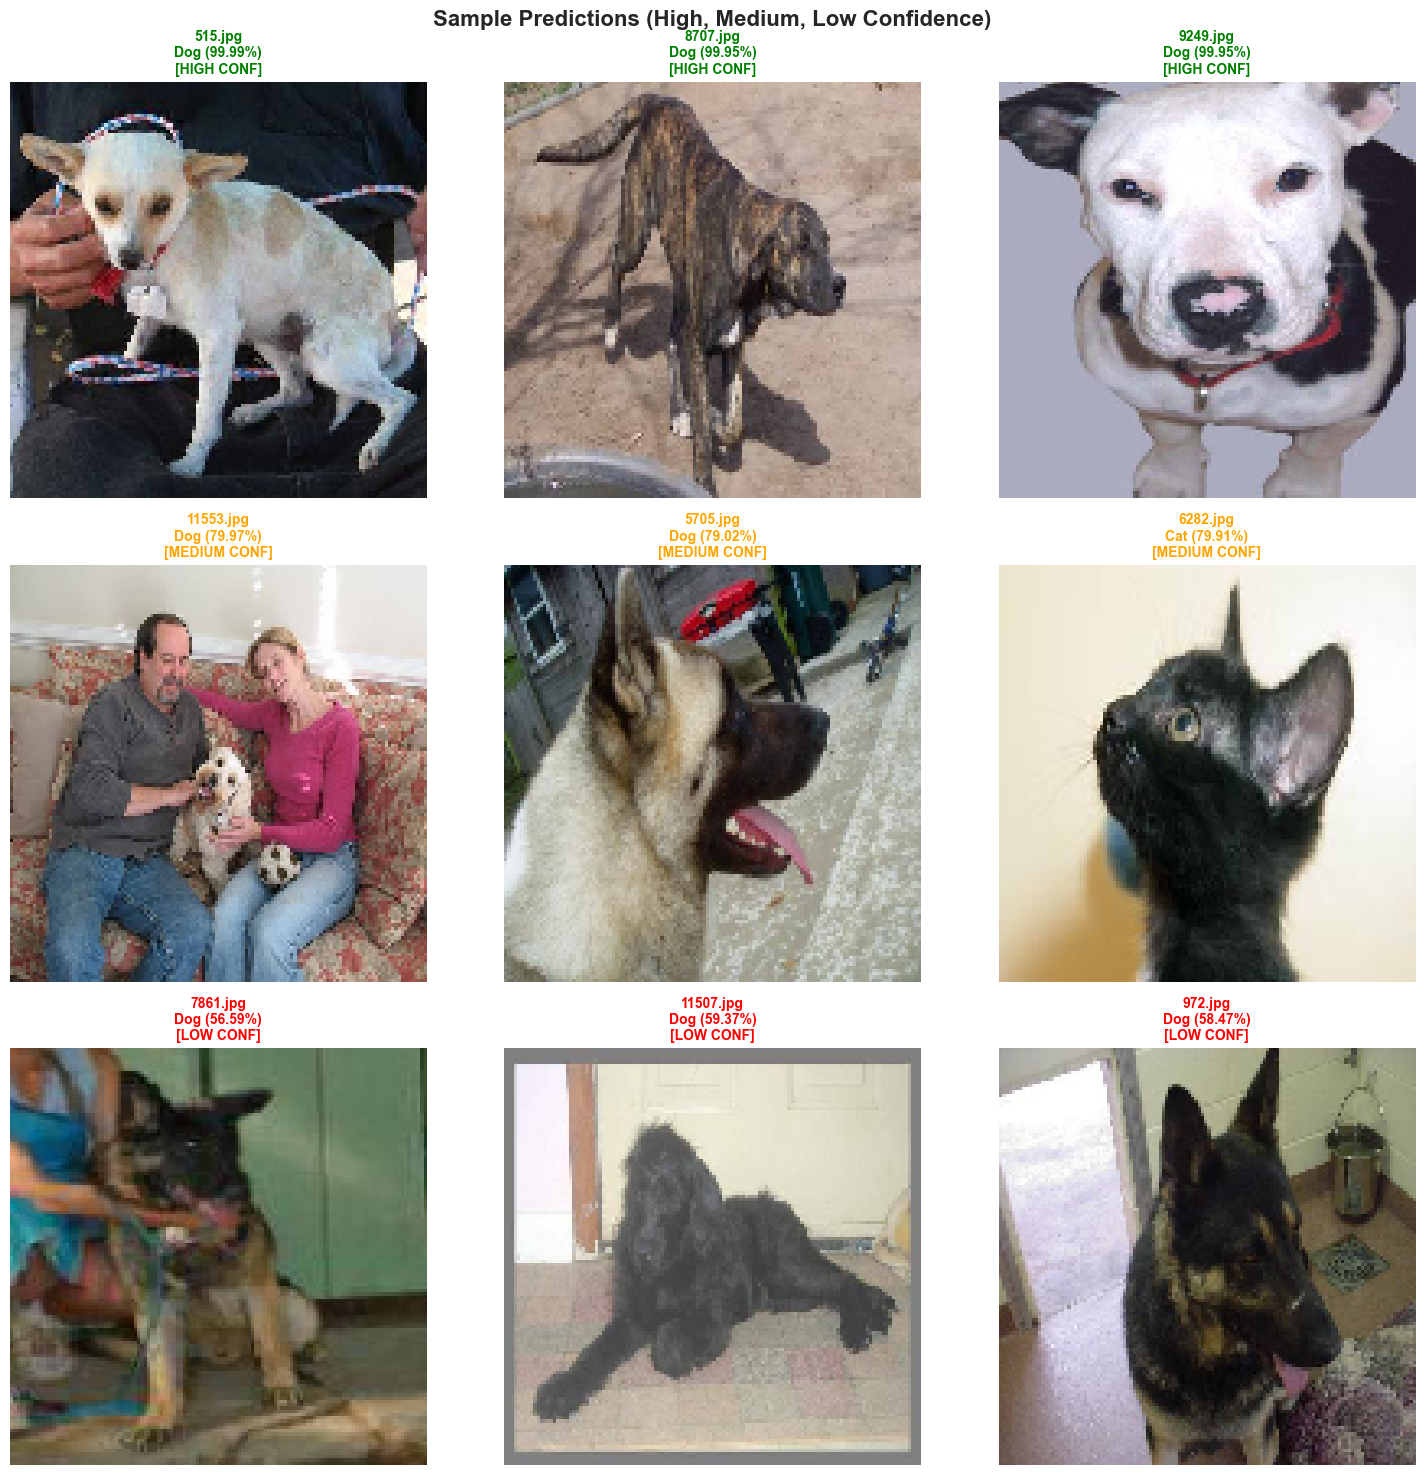


✓ Sample predictions saved to 'sample_predictions.png'


In [28]:
# Display sample predictions with images
import random

# Select random samples from high, medium, and low confidence predictions
high_conf = results_df[results_df['confidence'] > 0.9].sample(min(3, len(results_df[results_df['confidence'] > 0.9])))
medium_conf = results_df[(results_df['confidence'] >= 0.7) & (results_df['confidence'] <= 0.8)].sample(min(3, len(results_df[(results_df['confidence'] >= 0.7) & (results_df['confidence'] <= 0.8)])))
low_conf = results_df[results_df['confidence'] < 0.6].sample(min(3, len(results_df[results_df['confidence'] < 0.6])))

sample_images = pd.concat([high_conf, medium_conf, low_conf])

# Display sample images with predictions
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Sample Predictions (High, Medium, Low Confidence)', fontsize=16, fontweight='bold')

for idx, (_, row) in enumerate(sample_images.iterrows()):
    if idx >= 9:
        break
    
    ax = axes[idx // 3, idx % 3]
    
    # Load and display image
    img_path = os.path.join(TEST_FOLDER, row['filename'])
    try:
        img = image.load_img(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        ax.imshow(img)
        
        # Set title with prediction and confidence
        conf_level = 'HIGH' if row['confidence'] > 0.9 else ('MEDIUM' if row['confidence'] >= 0.7 else 'LOW')
        title_color = 'green' if row['confidence'] > 0.9 else ('orange' if row['confidence'] >= 0.7 else 'red')
        
        ax.set_title(f"{row['filename']}\n{row['prediction']} ({row['confidence']:.2%})\n[{conf_level} CONF]",
                    fontsize=10, fontweight='bold', color=title_color)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error loading\n{row["filename"]}', 
               ha='center', va='center', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.savefig('assets/sample_predictions.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✓ Sample predictions saved to 'assets/sample_predictions.png'")

## 9. Final Summary

In [29]:
# Final summary report
print("\n" + "="*70)
print("BENCHMARK COMPLETE")
print("="*70)
print(f"\nFiles Generated:")
print(f"  1. {OUTPUT_EXCEL} - Full predictions with embedded images")
print(f"  2. assets/test_results_visualization.png - Comprehensive analysis charts")
print(f"  3. assets/sample_predictions.png - Visual samples with predictions")
print(f"\nModel Performance:")
print(f"  • Processed {total_images:,} images in {duration:.2f} seconds")
print(f"  • Average confidence: {avg_confidence*100:.2f}%")
print(f"  • Images with >90% confidence: {len(results_df[results_df['confidence'] > 0.9]):,} ({len(results_df[results_df['confidence'] > 0.9])/total_images*100:.1f}%)")
print(f"  • Images with <60% confidence: {len(results_df[results_df['confidence'] < 0.6]):,} ({len(results_df[results_df['confidence'] < 0.6])/total_images*100:.1f}%)")
print(f"\nPrediction Breakdown:")
print(f"  • Cats: {cat_predictions:,} ({cat_predictions/total_images*100:.1f}%)")
print(f"  • Dogs: {dog_predictions:,} ({dog_predictions/total_images*100:.1f}%)")
print("="*70)


BENCHMARK COMPLETE

Files Generated:
  1. test_predictions.xlsx - Full predictions with embedded images
  2. test_results_visualization.png - Comprehensive analysis charts
  3. sample_predictions.png - Visual samples with predictions

Model Performance:
  • Processed 12,500 images in 57.79 seconds
  • Average confidence: 97.19%
  • Images with >90% confidence: 11,459 (91.7%)
  • Images with <60% confidence: 172 (1.4%)

Prediction Breakdown:
  • Cats: 6,078 (48.6%)
  • Dogs: 6,422 (51.4%)
